In [7]:
import math

import torch
import torch.nn as nn
from torch.nn.functional import softmax

import numpy as np
import matplotlib.pyplot as plt

In [8]:
def scaled_dot_product_attention(query, key, value, mask=None):
        """
        Args:
            query: (batch_size, num_heads, seq_len_q, d_k)
            key: (batch_size, num_heads, seq_len_k, d_k)
            value: (batch_size, num_heads, seq_len_v, d_v)
            mask: Optional mask to prevent attention to certain positions
        """

        query = torch.tensor(query)
        key = torch.tensor(key)
        value = torch.tensor(value)
        # how do i get the d_k from the above query matrix?
        d_k = query.size(-1)
        # calculate the attention score using the formula given. Be vary of the dimension of Q and K. And what you need to transpose to achieve the desired results.
        qk = torch.matmul(query, key.transpose(2,3))/math.sqrt(d_k)
        print(f"Multiplying Query and Key matrices: \n{qk})")
        # hint 1: batch_size and num_heads should not change
        # hint 2: nXm @ mXn -> nXn, but you cannot do nXm @ nXm, the right dimension of the left matrix should match the left dimension of the right matrix. The easy way I visualize it is as, who face each other must be same

        # add inf is a mask is given, This is used for the decoder layer. You can use help for this if you want to. I did!!
        #YOUR CODE HERE
        if mask is not None:
            qk = qk.masked_fill(mask == 0, float('-inf'))


        # get the attention weights by taking a softmax on the scores, again be wary of the dimensions. You do not want to take softmax of batch_size or num_heads. Only of the values. How can you do that?
        #YOUR CODE HERE
        softmax_qk = softmax(qk, dim=-1)
        print(f"After taking softmax: \n{softmax_qk}")

        scaled_attention = softmax_qk.matmul(value)
        print(f"Scaled Attention: \n{scaled_attention}")
        
        return scaled_attention

# Input embeddings

In [9]:
tokens = ['The', 'fox', 'jumps']

# 2. embedding dimension
embed_dim = 4

# 3. reproducible RNG
rng = np.random.default_rng(42)

In [10]:
# 4B. Toy sparse / interpretable embeddings (one-hot-like with slight offsets)
toy_emb = np.array([
    [1.0, 0.0, 0.0, 0.0],   # "The"
    [0.0, 1.0, 0.0, 0.0],   # "fox"
    [0.0, 0.0, 1.0, 0.0],   # "jumps"
], dtype=float)
# add a tiny offset so they aren't perfectly orthogonal if you want
toy_emb += np.array([[0.0, 0.01, 0.02, 0.0],
                     [0.01, 0.0, 0.02, 0.0],
                     [0.02, 0.01, 0.0, 0.0]])

In [11]:
# 6. Print embeddings
np.set_printoptions(precision=4, suppress=True)

print("\nToy embeddings (interpretable):")
for t, v in zip(tokens, toy_emb):
    print(f"{t:6s} -> {v}\n")


Toy embeddings (interpretable):
The    -> [1.   0.01 0.02 0.  ]

fox    -> [0.01 1.   0.02 0.  ]

jumps  -> [0.02 0.01 1.   0.  ]



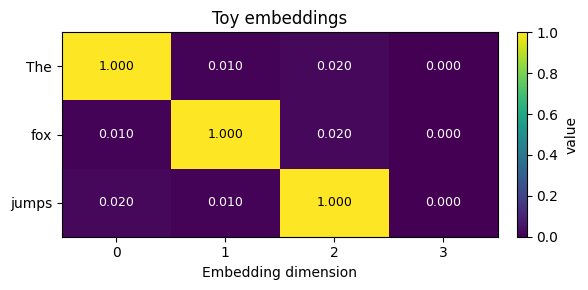

In [12]:
# Plot heatmap with annotations
fig, ax = plt.subplots(figsize=(6, 3))
cax = ax.imshow(toy_emb, cmap="viridis", aspect="auto")

# ticks and labels
ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(tokens)
ax.set_xticks(np.arange(toy_emb.shape[1]))
ax.set_xlabel("Embedding dimension")
ax.set_title("Toy embeddings")

# colorbar
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label="value")

# annotate values inside cells
for i in range(toy_emb.shape[0]):
    for j in range(toy_emb.shape[1]):
        val = toy_emb[i, j]
        ax.text(j, i, f"{val:.3f}", ha="center", va="center", color="white" if val < 0.5 else "black", fontsize=9)

plt.tight_layout()
plt.savefig("toy_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()

# Attention(Q,K,V) = softmax(Q K^T / sqrt(d_k)) V

# Linear Projections

In [14]:
proj_dim = 3  # dimension after linear projection (e.g., d_k = d_v = 3)

# Deterministic projection matrices (embed_dim -> proj_dim)
rng = np.random.default_rng(12345)
W_q = rng.uniform(-1.0, 1.0, size=(embed_dim, proj_dim))
W_k = rng.uniform(-1.0, 1.0, size=(embed_dim, proj_dim))
W_v = rng.uniform(-1.0, 1.0, size=(embed_dim, proj_dim))

/tmp/ipykernel_32247/3879638574.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


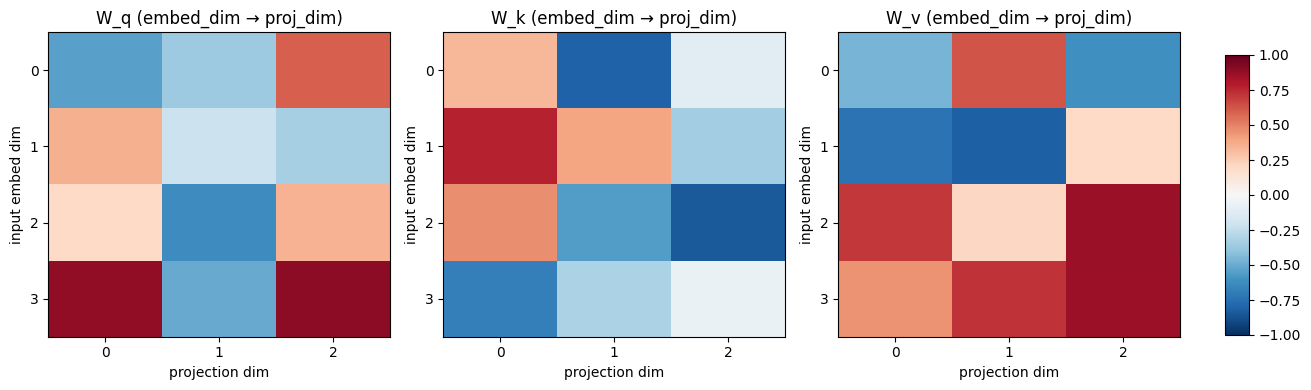

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
mats = [W_q, W_k, W_v]
titles = ["W_q (embed_dim → proj_dim)", "W_k (embed_dim → proj_dim)", "W_v (embed_dim → proj_dim)"]

for ax, M, t in zip(axes, mats, titles):
    im = ax.imshow(M, aspect="auto", cmap="RdBu_r", vmin=-1, vmax=1)
    ax.set_title(t)
    ax.set_xlabel("projection dim")
    ax.set_ylabel("input embed dim")
    ax.set_xticks(range(proj_dim))
    ax.set_yticks(range(embed_dim))
    ax.grid(False)

# cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
cax_pos = [1.025, 0.15, 0.02, 0.7]  # [left, bottom, width, height] in figure coordinates
cax = fig.add_axes(cax_pos)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
fig.tight_layout()
plt.savefig("projection_dim.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Linear projections
Q = toy_emb @ W_q
K = toy_emb @ W_k
V = toy_emb @ W_v

## Visualizing projections

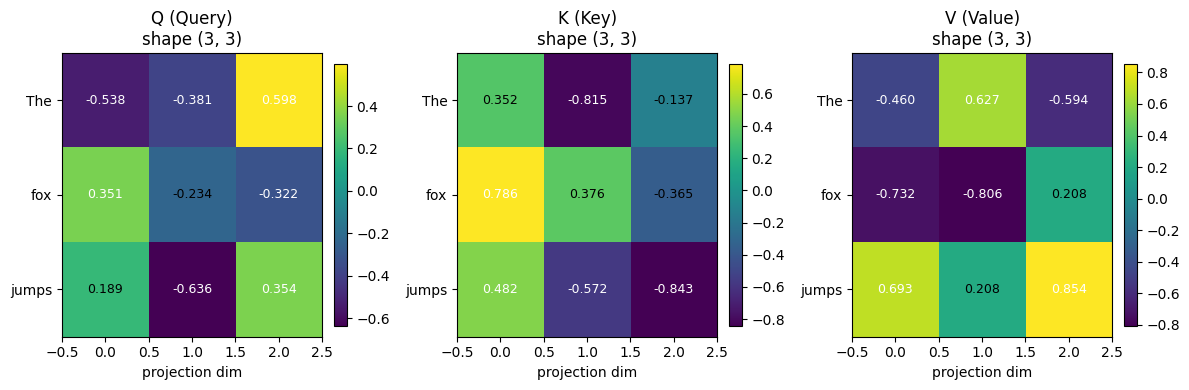

In [18]:
matrices = [(Q, "Q (Query)"), (K, "K (Key)"), (V, "V (Value)")]
n = len(matrices)

fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
if n == 1:
    axes = [axes]

for ax, (mat, title) in zip(axes, matrices):
    im = ax.imshow(mat, cmap="viridis", aspect="auto")
    ax.set_title(f"{title}\nshape {mat.shape}")
    ax.set_xlabel("projection dim")
    # set y ticks to tokens if available and length matches, else indices
    try:
        if 'tokens' in globals() and len(tokens) == mat.shape[0]:
            ax.set_yticks(np.arange(len(tokens)))
            ax.set_yticklabels(tokens)
        else:
            ax.set_yticks(np.arange(mat.shape[0]))
            ax.set_yticklabels([str(i) for i in range(mat.shape[0])])
    except Exception:
        ax.set_yticks(np.arange(mat.shape[0]))
        ax.set_yticklabels([str(i) for i in range(mat.shape[0])])

    # annotations
    abs_max = max(1e-9, np.max(np.abs(mat)))
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat[i, j]
            color = "white" if abs(val) > abs_max / 2 else "black"
            ax.text(j, i, f"{val:.3f}", ha="center", va="center", color=color, fontsize=9)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("qkv.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate attention scores

### attention scores = (Q @ K^T) / sqrt(d_k)

In [19]:
# Convert to tensors
Q_t = torch.as_tensor(Q, dtype=torch.float32)
K_t = torch.as_tensor(K, dtype=torch.float32)
V_t = torch.as_tensor(V, dtype=torch.float32)

# projection dimension
d_k = proj_dim

In [20]:
scores = torch.matmul(Q_t, K_t.transpose(0, 1)) 

In [21]:
scores

tensor([[ 0.0401, -0.7841, -0.5455],
        [ 0.3581,  0.3052,  0.5740],
        [ 0.5368, -0.2195,  0.1567]])

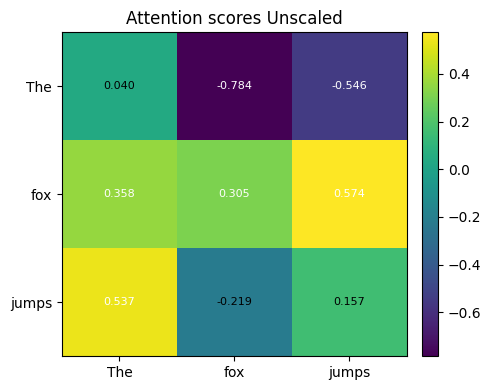

In [22]:
scores_np = scores.numpy()
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(scores_np, cmap="viridis", aspect="auto")
ax.set_title(f"Attention scores Unscaled")
if tokens is not None and len(tokens) == scores_np.shape[0]:
    ax.set_yticks(np.arange(len(tokens))); ax.set_yticklabels(tokens)
    ax.set_xticks(np.arange(len(tokens))); ax.set_xticklabels(tokens)
else:
    ax.set_xlabel("key position"); ax.set_ylabel("query position")
for i in range(scores_np.shape[0]):
    for j in range(scores_np.shape[1]):
        ax.text(j, i, f"{scores_np[i,j]:.3f}", ha="center", va="center",
                color="white" if abs(scores_np[i,j]) > (scores_np.max()/2) else "black", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.savefig("unscaled_attention.png", dpi=300, bbox_inches='tight')
plt.tight_layout(); plt.show()

### After scaling

In [23]:
scores = scores / math.sqrt(d_k)

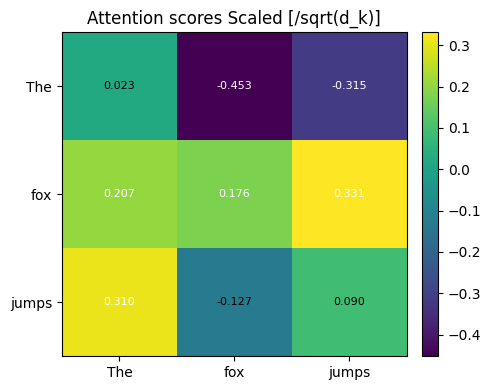

In [24]:
scores_np = scores.numpy()
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(scores_np, cmap="viridis", aspect="auto")
ax.set_title(f"Attention scores Scaled [/sqrt(d_k)]")
if tokens is not None and len(tokens) == scores_np.shape[0]:
    ax.set_yticks(np.arange(len(tokens))); ax.set_yticklabels(tokens)
    ax.set_xticks(np.arange(len(tokens))); ax.set_xticklabels(tokens)
else:
    ax.set_xlabel("key position"); ax.set_ylabel("query position")
for i in range(scores_np.shape[0]):
    for j in range(scores_np.shape[1]):
        ax.text(j, i, f"{scores_np[i,j]:.3f}", ha="center", va="center",
                color="white" if abs(scores_np[i,j]) > (scores_np.max()/2) else "black", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.savefig("scaled_attention.png", dpi=300, bbox_inches='tight')
plt.tight_layout(); plt.show()

### After softmax

In [25]:
softmax_qk = softmax(scores, dim=-1)

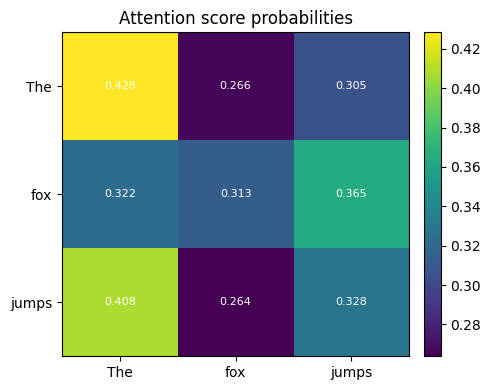

In [26]:
scores_np = softmax_qk.numpy()
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(scores_np, cmap="viridis", aspect="auto")
ax.set_title(f"Attention score probabilities")
if tokens is not None and len(tokens) == scores_np.shape[0]:
    ax.set_yticks(np.arange(len(tokens))); ax.set_yticklabels(tokens)
    ax.set_xticks(np.arange(len(tokens))); ax.set_xticklabels(tokens)
else:
    ax.set_xlabel("key position"); ax.set_ylabel("query position")
for i in range(scores_np.shape[0]):
    for j in range(scores_np.shape[1]):
        ax.text(j, i, f"{scores_np[i,j]:.3f}", ha="center", va="center",
                color="white" if abs(scores_np[i,j]) > (scores_np.max()/2) else "black", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.savefig("attention_probs.png", dpi=300, bbox_inches='tight')
plt.tight_layout(); plt.show()

### After scaling with values matrix

In [27]:
scaled_attention = softmax_qk.matmul(V_t)

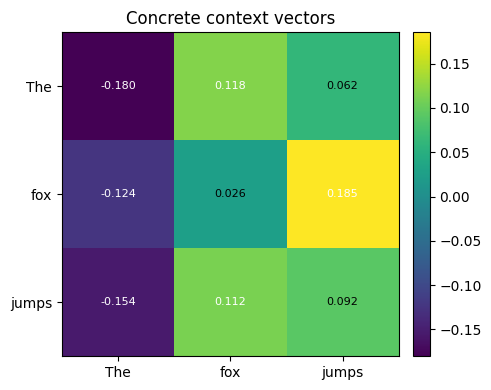

In [28]:
scores_np = scaled_attention.numpy()
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(scores_np, cmap="viridis", aspect="auto")
ax.set_title(f"Concrete context vectors")
if tokens is not None and len(tokens) == scores_np.shape[0]:
    ax.set_yticks(np.arange(len(tokens))); ax.set_yticklabels(tokens)
    ax.set_xticks(np.arange(len(tokens))); ax.set_xticklabels(tokens)
else:
    ax.set_xlabel("key position"); ax.set_ylabel("query position")
for i in range(scores_np.shape[0]):
    for j in range(scores_np.shape[1]):
        ax.text(j, i, f"{scores_np[i,j]:.3f}", ha="center", va="center",
                color="white" if abs(scores_np[i,j]) > (scores_np.max()/2) else "black", fontsize=8)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout(); 
plt.savefig("context_vectors.png", dpi=300, bbox_inches='tight')
plt.show()